<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab_5_UnsupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning on the Dry Bean Dataset

In this lab we will try to obtain valuable information using Unsupervised Learning techniques.

The original data has been downloaded from https://archive-beta.ics.uci.edu/dataset/602/dry+bean+dataset (Dry Bean Dataset. (2020). UCI Machine Learning Repository)

**Data Set Description**:

Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera.
A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.

## Loading and Pre-treatment of the Data

In [2]:
# Load libraries and modules
import pandas as pd
from sklearn import preprocessing
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.metrics.cluster import normalized_mutual_info_score
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
FFILE = './Dry_Bean_Dataset.xlsx'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/Lab5/Dry_Bean_Dataset.xlsx"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/Lab5/Dry_Bean_Dataset.xlsx"

File already exists
File is readable


In [4]:
# Load the data
data = pd.read_excel('./Dry_Bean_Dataset.xlsx')
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [5]:
# Transform the data to use it as numpy arrays.
X = data.iloc[:,:-1].values
label = data.iloc[:,16].values
print(X.shape)
N = X.shape[0]  # Number of data points
nc = X.shape[1]  # Number of features/components
print(np.unique(label))

(13611, 16)
['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']


In [6]:
# Creating an ordinal encoder for the ground truth labels
ordinal_encoder = preprocessing.OrdinalEncoder()

# Fitting the encoder to the label data
ordinal_encoder.fit(label.reshape(-1, 1)) #reshape -->trasformazione a vettore colonna

# Transforming the original labels into encoded forms
y = ordinal_encoder.transform(label.reshape(-1, 1))

# Printing the encoded labels
print(y)

[[5.]
 [5.]
 [5.]
 ...
 [3.]
 [3.]
 [3.]]


In [7]:
# Rescaling the features of the data to handle different units: subtracting the mean and dividing by the standard deviation
scaler = preprocessing.StandardScaler().fit(X)

# Transforming the original data using the calculated mean and standard deviation
X_scaled = scaler.transform(X)

In [8]:
X_scaled

array([[-0.84074853, -1.1433189 , -1.30659814, ...,  2.40217287,
         1.92572347,  0.83837103],
       [-0.82918764, -1.01392388, -1.39591111, ...,  3.10089314,
         2.68970162,  0.77113842],
       [-0.80715717, -1.07882906, -1.25235661, ...,  2.23509147,
         1.84135576,  0.91675514],
       ...,
       [-0.37203825, -0.44783294, -0.45047814, ...,  0.28920441,
         0.33632829,  0.39025114],
       [-0.37176543, -0.42702856, -0.42897404, ...,  0.22837538,
         0.2489734 ,  0.03644001],
       [-0.37135619, -0.38755718, -0.2917356 , ..., -0.12777587,
        -0.2764814 ,  0.71371948]])

## Principal Component Analysis (PCA)

**Objective**: find the set of orthogonal directions along which the variance of the data is the highest.

Summary of the method:

* Center the data feature matrix $X$;

* Compute the covariance matrix $C$ of the data as $C=X^T X$;

* Compute eigenvalues and eigenvectors of the covariance matrix $C$ (using the function `eigh` of the `scipy.LA` module), and sort them according to the decreasing order of the eigenvalues. Arrange them as coumn of a matrix $A$.

**Recall**: eigenvalues are the variance of the data along the direction of the corresponding eigenvector.

* Compute principal components as $X\cdot A$

In [9]:
# Since the features are already centered, we compute the covariance matrix as:
#Covariance matrix C = X^T * X
C = np.dot(X_scaled.T, X_scaled)

# Calculating eigenvectors and eigenvalues of the covariance matrix

eigenvalues, eigenvectors = eigh(C)

# Sorting eigenvalues and corresponding eigenvectors in descending order
index_sort = np.argsort(-eigenvalues)
sorted_eigenvalues = [eigenvalues[i] for i in index_sort]
sorted_eigenvectors = [eigenvectors[i] for i in index_sort]

A = np.stack(sorted_eigenvectors, axis=1)

# Projecting the original data onto the principal components
my_pca = np.dot(X_scaled,A)

### Model Assessment: choose the number of PCs to keep

**Objective**: choose the final dimension $d$ of the transformed data.

1. Proportion of variance explained: given eigenvalues $\lambda_i$ of the covariance matrix and a threshold $t\in [0, 1]$, choose $d$ s.t. the ratio $\chi_d = \frac{\sum_{i=1}^d \lambda_i}{\sum_{i=1}^D \lambda_i} > t$

2. Check the existence of a gap in the spectrum of the covariance matrix.

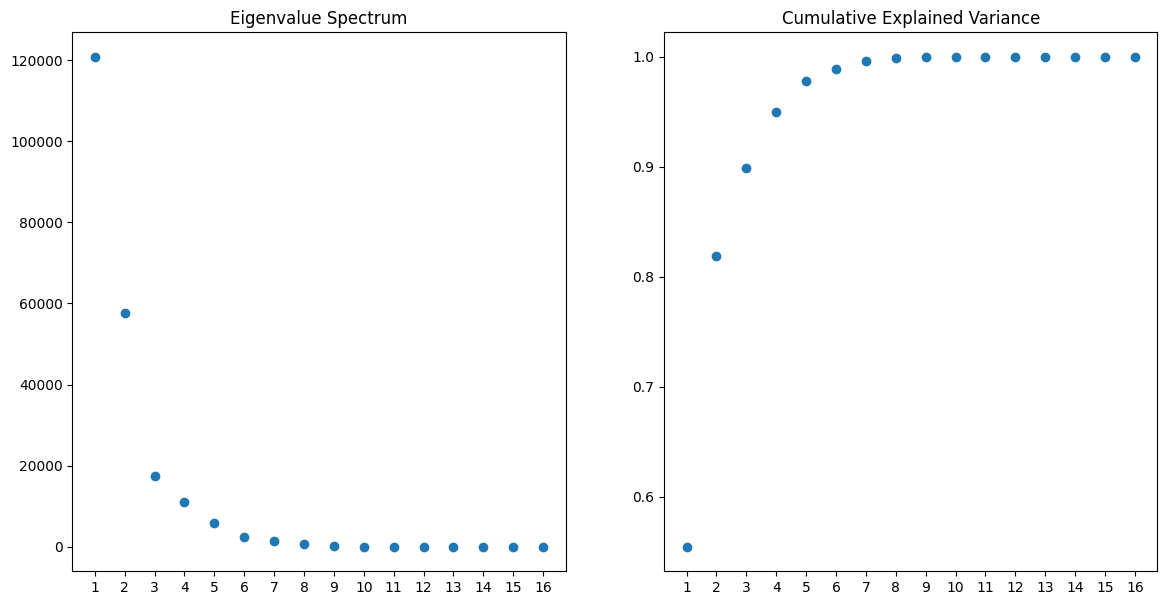

In [10]:
# Calculating the cumulative proportion of explained variance
cumulative_variance = np.zeros(nc)
total_variance = np.sum(sorted_eigenvalues)

# Accumulating the proportion of variance explained up to each component
for i in range(nc):
    cumulative_variance[i] = np.sum(sorted_eigenvalues[:i+1]) / total_variance

# Generating an array representing the components for visualization
eigenvalues = sorted_eigenvalues[:i+1]
components = np.arange(nc) + 1

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 7))

# Plotting the Spectrum
ax1.set_title('Eigenvalue Spectrum')
ax1.scatter(components, eigenvalues)
ax1.set_xticks(components)

# Plotting the Cumulative Explained Variance
ax2.set_title('Cumulative Explained Variance')
ax2.scatter(components, cumulative_variance)
ax2.set_xticks(components)

# Displaying the plots
plt.show()


In [11]:
for threshold in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    num_components = np.argmax(cumulative_variance - threshold > 0.) + 1
    print(f"Explained Variance Threshold: {threshold}, Number of Components: {num_components}")

Explained Variance Threshold: 0.8, Number of Components: 2
Explained Variance Threshold: 0.85, Number of Components: 3
Explained Variance Threshold: 0.9, Number of Components: 4
Explained Variance Threshold: 0.95, Number of Components: 4
Explained Variance Threshold: 0.97, Number of Components: 5
Explained Variance Threshold: 0.99, Number of Components: 7
Explained Variance Threshold: 0.999, Number of Components: 8


In [12]:
# Performing Principal Component Analysis (PCA) using sklearn
pca = PCA()

# Fitting the PCA model to the scaled data
pca.fit(X_scaled)

# Transforming the original data to the principal components
projection = pca.transform(X_scaled)

# Calculating the cumulative explained variance ratio
cumulative_variance = np.zeros(nc)
for i in range(nc):
    cumulative_variance[i] = np.sum(pca.explained_variance_ratio_[:i+1])

# Extracting eigenvalues and component indices
eigenvalues = pca.explained_variance_
components  = np.arange(nc) + 1

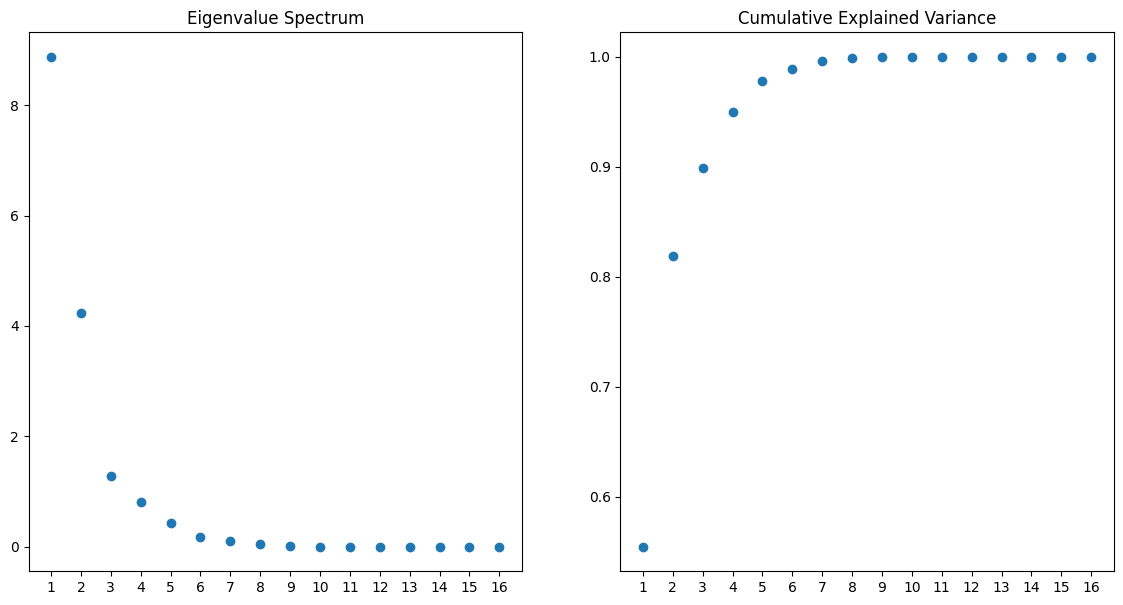

In [13]:
# Creating subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 7))

# Plotting the Spectrum
ax1.set_title('Eigenvalue Spectrum')
ax1.scatter(components, eigenvalues)
ax1.set_xticks(components)

# Plotting the Cumulative Explained Variance
ax2.set_title('Cumulative Explained Variance')
ax2.scatter(components, cumulative_variance)
ax2.set_xticks(components)

# Displaying the plots
plt.show()

In [14]:
# Determine the number of components based on different explained variance thresholds.
for threshold in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    # Find the index where cumulative variance exceeds the threshold
    num_components = np.argmax(cumulative_variance - threshold > 0.) + 1

    # Print the threshold and the corresponding number of components
    print(f"Explained Variance Threshold: {threshold}, Number of Components: {num_components}")


Explained Variance Threshold: 0.8, Number of Components: 2
Explained Variance Threshold: 0.85, Number of Components: 3
Explained Variance Threshold: 0.9, Number of Components: 4
Explained Variance Threshold: 0.95, Number of Components: 4
Explained Variance Threshold: 0.97, Number of Components: 5
Explained Variance Threshold: 0.99, Number of Components: 7
Explained Variance Threshold: 0.999, Number of Components: 8


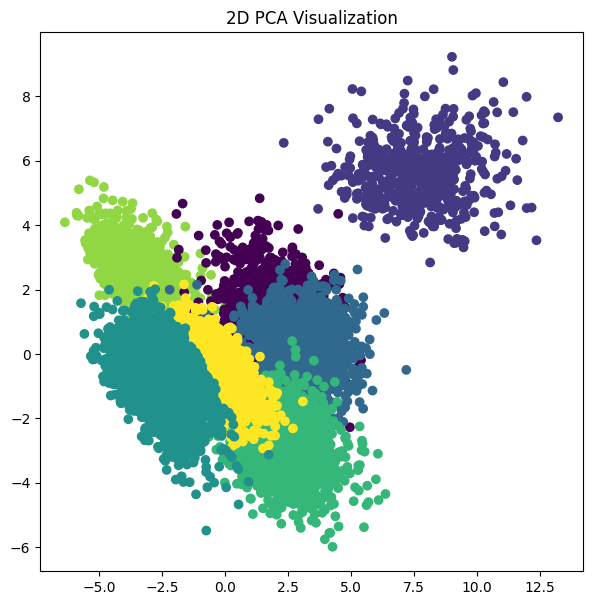

In [15]:
# Plotting the 2D representation of the dataset using the first two Principal Components (PCs),
# with points colored by their ground truth labels.
fig, ax = plt.subplots(figsize=(7, 7))

# Scatter plot of the dataset in 2D space using the first two Principal Components
ax.scatter(projection[:, 0], projection[:, 1], c=y)

# Setting the title of the plot
ax.set_title('2D PCA Visualization')

# Displaying the plot
plt.show()

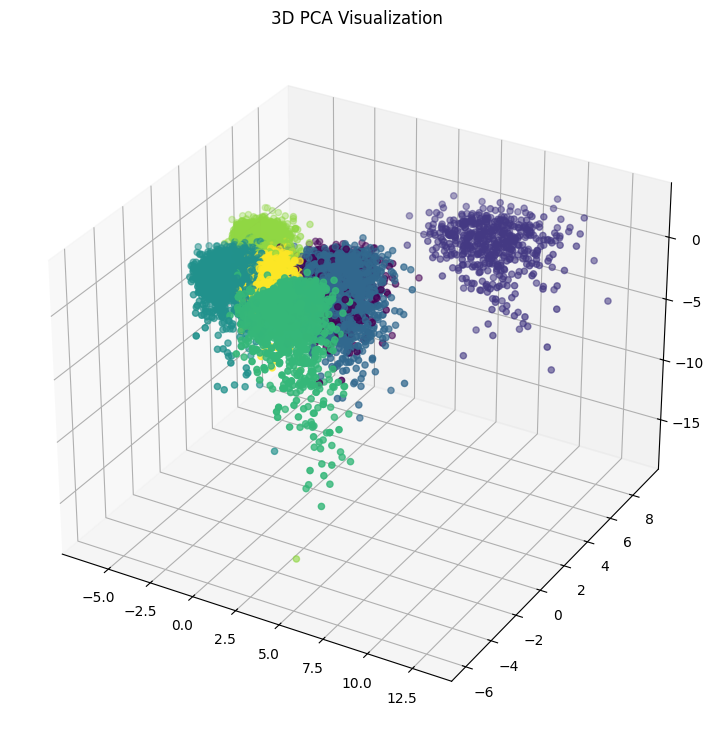

In [16]:
# Plotting the 3D representation of the dataset using the first three Principal Components (PCs),
# with points colored by their ground truth labels.
fig = plt.figure(figsize=(9, 9))

# Creating a 3D subplot
ax = fig.add_subplot(projection='3d')

# Scatter plot of the dataset in 3D space using the first three Principal Components
ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=y)

# Setting the title of the plot
ax.set_title('3D PCA Visualization')

# Displaying the 3D plot
plt.show()

1. What would happen if we don't rescale the features?

2. Which is the Intrinsic Dimension (ID) of the data set?

  **Recall**: the ID of a dataset is the minimum number of dimensions we need to describe the data in a accurate way.

3. Could you compute the two-NN estimate of the ID?

  The procedure works as follows:

  1. Compute pairwise distances among points;
  2. For each point $i$, extract the distance from its two closest neighbors $r_{i1}, r_{i2}$ respectively;
  3. Compute the ratio $\mu_i = \frac{r_{i2}}{r_i1}$;
  4. Compute the empirical cumulative distribution $\mathcal{F}(\mu)$ of $\mu$;
  5. Find the best fitting line for the dataset $\{\log \mu_i, \log (1 - \mathcal{F}(\mu_i)\}_{i=1}^N$
  6. The intrinsic dimension is given by the slope of this fitted line.

In [17]:
# Compute the pairwise Euclidean distance matrix between unique rows of the scaled dataset
unique_scaled_data = np.unique(X_scaled, axis=0)
distance_matrix = cdist(unique_scaled_data, unique_scaled_data)
distance_matrix.sort(axis=1)

# Calculate the ratio of the second-nearest neighbor distance to the nearest neighbor distance
mu_i = np.divide(distance_matrix[:, 2], distance_matrix[:, 1])

# Compute the logarithm of the calculated ratios
log_mu_i = np.log(mu_i)

# Calculate the inverse of the mean logarithm of the second-nearest neighbor ratios
two_nn = 1 / np.mean(log_mu_i)

# Print the resulting value
print("Two-Nearest-Neighbor (2NN) Distance Measure:", two_nn)
#seee DADAPY

Two-Nearest-Neighbor (2NN) Distance Measure: 5.707929194326163


## K-means

Flat clustering algorithm whose goal is to minimize the intracluster distance while maximizing the intercluster distance.

We will compute the k-means clustering using two types of initialization:
    
  1. Random initialization: cluster centroids are initialized picking random points from the dataset;
  
  2. k-means++: choose first cluster center at random, then choose new cluster centers in such a way that they are far from existing centers.

In [18]:
def k_means_internal(k, X, init):
    '''
    Perform k-means clustering.

    Parameters
    ----------
    k : int
        Number of clusters.
    X : matrix of dimension N x D
        Dataset.
    init : str, {'++', 'random'}
        Type of initialization for k-means algorithm.

    Returns
    -------
    tuple
        z_new : array
            Cluster assignments for each data point.
        L : float
            Final value of the k-means objective function (loss).
        niter : int
            Number of iterations performed.
    '''
    N = X.shape[0]  # number of points
    nc = X.shape[1]  # number of coordinates
    ll = np.arange(k)
    z = np.zeros(N, dtype='int')  # cluster number assigned to each data point
    cent = np.zeros([k, nc])  # coordinates of the cluster centers

    # k-means++
    if init == '++':
        b = np.random.choice(N, 1, replace=False)  # choose the first cluster center at random
        cent[0, :] = X[b, :]
        nchosen = 1  # number of cluster centers already set

        while nchosen < k:
            dist = cdist(cent[:nchosen, :], X)  # distance of each point from the cluster centers
            dmin = np.min(dist, axis=0)  # min distance between point and cluster centers
            prob = dmin**2
            prob = prob / np.sum(prob)

            # choose next center according to the computed prob
            b = np.random.choice(N, 1, replace=False, p=prob)
            cent[nchosen, :] = X[b, :]
            nchosen += 1

    # random initialization
    else:
        b = np.random.choice(N, k, replace=False)  # choose the k centers randomly
        for i in ll:
            cent[i, :] = X[b[i], :]

    dist = cdist(cent, X)  # distance of each point from cluster centers
    z_new = np.argmin(dist, axis=0)  # assign each point to cluster with the closest center
    dmin = np.min(dist, axis=0)
    niter = 0
    L = np.sum(dmin**2)  # loss function evaluation

    while (z_new != z).any():  # until a stable configuration is reached
        z = np.copy(z_new)

        for i in range(k):
            cent[i, :] = np.average(X[z == i, :], axis=0)  # compute cluster centroids

        dist = cdist(cent, X)  # update distances from cluster centers
        z_new = np.argmin(dist, axis=0)  # find cluster with the minimum centroid distance
        dmin = np.min(dist, axis=0)
        L = np.sum(dmin**2)  # loss function evaluation
        niter += 1

    return z_new, L, niter


In [19]:
def k_means(k, X, init='++', n_init=20):
    '''
    Perform k-means clustering with multiple initializations to find the best result.

    Parameters
    ----------
    k : int
        Number of clusters.
    X : matrix of dimension N x D
        Dataset.
    init : str, {'++', 'random'}, optional
        Type of initialization for k-means algorithm.
    n_init : int, optional
        Number of runs of the algorithm with different initializations.

    Returns
    -------
    tuple
        labels_opt : array
            Cluster assignments for each data point in the best-performing iteration.
        lmin : float
            Loss (objective function) for the best-performing iteration.
    '''
    lmin = float('inf')  # Initialize with a large value
    labels_opt = None

    for i in range(n_init):
        # Run k-means for each initialization
        labels, loss, niter = k_means_internal(k, X, init=init)

        # Check if the current iteration has a lower loss
        if loss < lmin:
            lmin = loss
            labels_opt = labels

    return labels_opt, lmin


### k-means with a fixed number of clusters

In [20]:
X_scaled

array([[-0.84074853, -1.1433189 , -1.30659814, ...,  2.40217287,
         1.92572347,  0.83837103],
       [-0.82918764, -1.01392388, -1.39591111, ...,  3.10089314,
         2.68970162,  0.77113842],
       [-0.80715717, -1.07882906, -1.25235661, ...,  2.23509147,
         1.84135576,  0.91675514],
       ...,
       [-0.37203825, -0.44783294, -0.45047814, ...,  0.28920441,
         0.33632829,  0.39025114],
       [-0.37176543, -0.42702856, -0.42897404, ...,  0.22837538,
         0.2489734 ,  0.03644001],
       [-0.37135619, -0.38755718, -0.2917356 , ..., -0.12777587,
        -0.2764814 ,  0.71371948]])

In [21]:
kmeans_labels, l_kmeans = k_means(7, X_scaled, init='++', n_init=20)
print(l_kmeans)

48811.94440005567


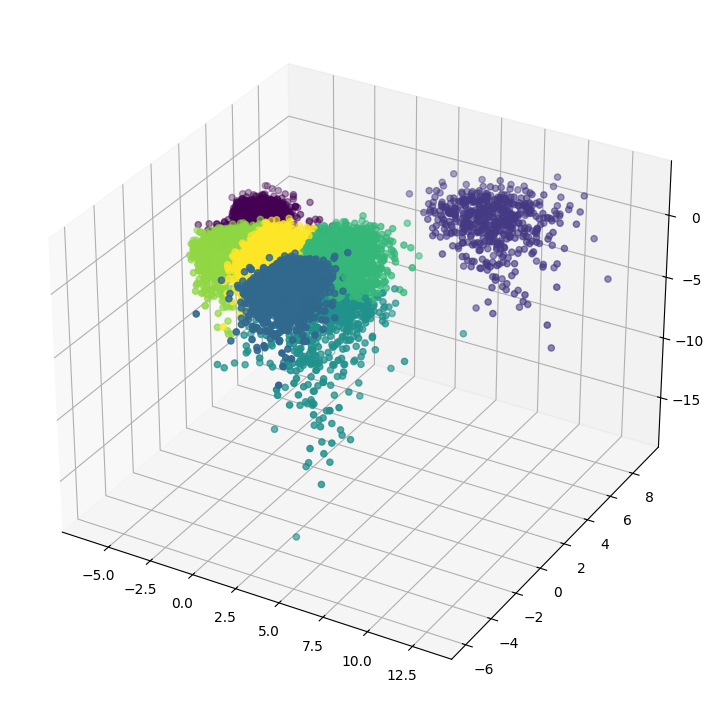

In [22]:
# Plot the projection according to the k-means clusters
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans_labels)
plt.show()

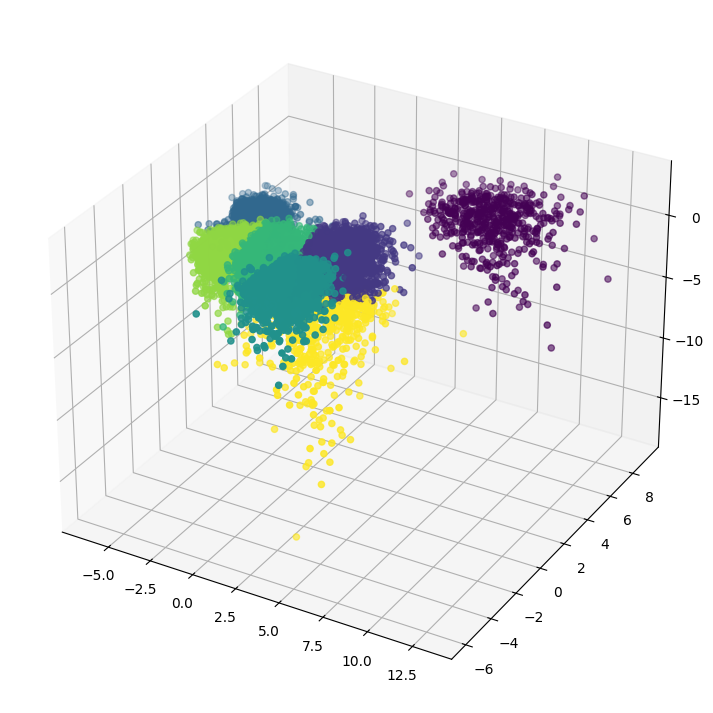

0.7139632055034241

In [23]:
# k is set to the ground truth number of clusters
kmeans = KMeans(n_clusters=7, random_state=0, n_init=20).fit(X_scaled)
# Plot the projection according to the k-means clusters
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans.labels_)
plt.show()
normalized_mutual_info_score(kmeans.labels_, y.flatten())

### Cluster Validation

Several methods:

* (Normalized) Mutual Information: it measure the agreement of the label assegned by k-means vs true labels;

* Scree Plot: perform k-means with different number of clusters, register the loss. Plot the loss as function of the number of the classes. An elbow in the scree plot should provide useful information about the parameter $k$.

In [24]:
# Compute the normalized mutual information between the predicted and the ground truth classification
normalized_mutual_info_score(kmeans_labels, y.flatten())

0.71378794072991

In [25]:
# Scree plot to determine the optimal number of clusters (k) using k-means algorithm

# Possible values for k in k-means
nk_base = np.arange(2, 21)

# Initialize an array to store the loss values for each k
loss = np.zeros(nk_base.shape[0])

# Iterate over each value of k and compute the k-means loss
for i, nk in enumerate(nk_base):
    labels, l_kmeans = k_means(nk, X_scaled, init='++', n_init=20)
    loss[i] = l_kmeans

# Create a scatter plot of k versus the log of the loss
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(nk_base, np.log(loss), c='b')

# Set x-axis ticks to the possible values for k
ax.set_xticks(nk_base)

# Set plot title
ax.set_title('Scree Plot')

# Display the plot
plt.show()

KeyboardInterrupt: 

### Build the scree plot

In order to locate approximately the elbow, we fit the first, let's say 4 points with a line and the last 4 points with a line, then the elbow will be approximately at the intersection.

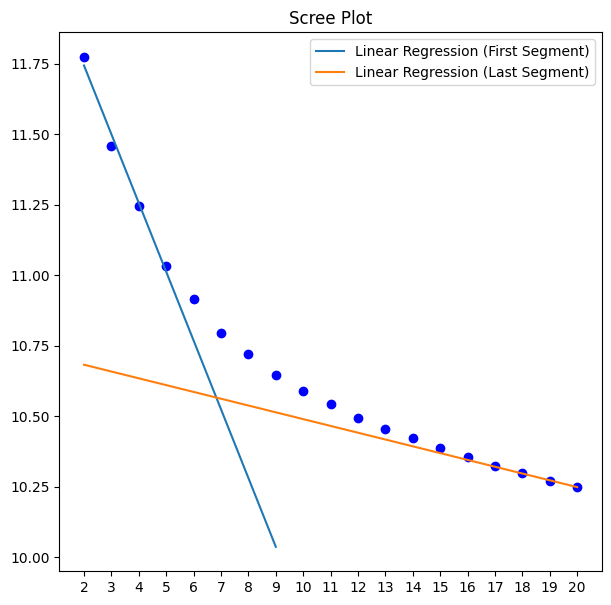

In [ ]:
# Scree plot with linear regression lines for different segments to aid in determining the optimal number of clusters (k)

# Possible values for k in k-means
nk_base = np.arange(2, 21)

# Initialize an array to store the loss values for each k
loss = np.zeros(nk_base.shape[0])

# Iterate over each value of k and compute the k-means loss
for i, nk in enumerate(nk_base):
    kmeans = KMeans(n_clusters=nk, random_state=0, n_init=20).fit(X_scaled)
    loss[i] = kmeans.inertia_

# Fit linear regression models for the first four points and the last four points
reg_first_segment = LinearRegression().fit(nk_base[:4].reshape(-1, 1), np.log(loss[:4]))
reg_last_segment = LinearRegression().fit(nk_base[16:20].reshape(-1, 1), np.log(loss[16:20]))

# Predict values using the linear regression models
predicted_first_segment = reg_first_segment.predict(nk_base[:8].reshape(-1, 1))
predicted_last_segment = reg_last_segment.predict(nk_base.reshape(-1, 1))

# Create a scatter plot of k versus the log of the loss
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(nk_base, np.log(loss), c='b')

# Set x-axis ticks to the possible values for k
ax.set_xticks(nk_base)

# Set plot title
ax.set_title('Scree Plot')

# Plot linear regression lines for the first and last segments
ax.plot(nk_base[:8], predicted_first_segment[:8], label='Linear Regression (First Segment)')
ax.plot(nk_base, predicted_last_segment, label='Linear Regression (Last Segment)')

# Display the legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
print(nk_base[:4].reshape(-1,1))

[[2]
 [3]
 [4]
 [5]]


Which is the optimal number of clusters according with the scree plot?

What happens if you don't initialize many times the algorithm?

## Play with other algorithms dimensionality reduction/clustering algorithms.

Try to obtain more information using other algorithms that we have seen during the lectures. Among the suggested algorithms, you can use ISOMAP or t-SNE for dimensional reduction, ward's hierarchical clustering, GMM or DBSCAN for clustering. You don't need to implement these algorithms, use any of the libraries in which them are already implemented (sklearn/scipy).

Since it's relatively easy, you can try to implement Density Peaks clustering.

### t-SNE (t-distributed stochastic neighbor embedding)

**Goal**: estimate, from the distances in the high- dimensional space, the probability of each point to be a neighbor of each other point. Then, the algorithm goal is to obtain a set of projected coordinates in which these “neighborhood probabilities” are as similar as possible to the ones in the original space.

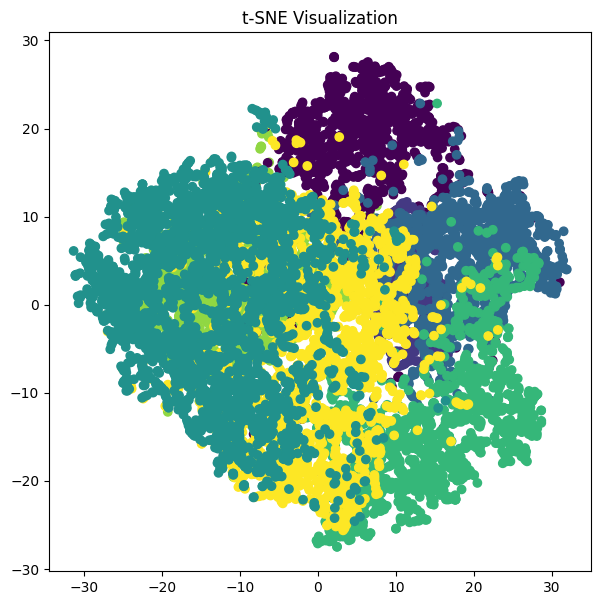

In [ ]:
# Use t-SNE to embed high-dimensional data into a 2D space for visualization
from sklearn.manifold import TSNE

# Embed the data into 2D using t-SNE
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=15).fit_transform(X_scaled)

# Create a scatter plot of the embedded data, colored by ground truth labels
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1],X_embedded[:,2], c=y)

# Set plot title
ax.set_title('t-SNE Visualization')

# Display the plot
plt.show()

### DBSCAN (density-based spatial clustering of application with noise)

**Goal**: clusters are connected regions with density above a threshold surrounded by regions with a density below this threshold. The density threshold is defined by two parameters: a neighborhood distance (*eps*) and the minimum number of configurations within this distance needed for considering a given configuration above the density threshold (*min_samples*)

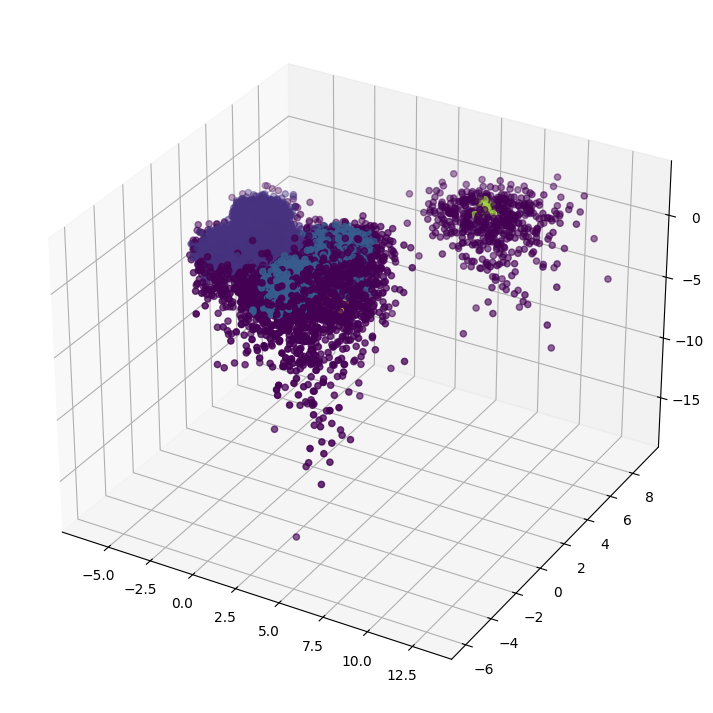

In [31]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering algorithm to the scaled data
dbscan = DBSCAN(eps=0.7, min_samples=12).fit(X_scaled)

# Visualize the clusters in a 3D scatter plot using the first three Principal Components
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=dbscan.labels_)

# Display the 3D plot
plt.show()


### Agglomerative Clustering (hierarchical clustering)

**Goal**: each configuration is initially assigned to a different cluster. At every iteration two existing clusters (i.e. the two closest according to the chosen criterion) are combined, so the next level of the dendrogram has one fewer cluster.



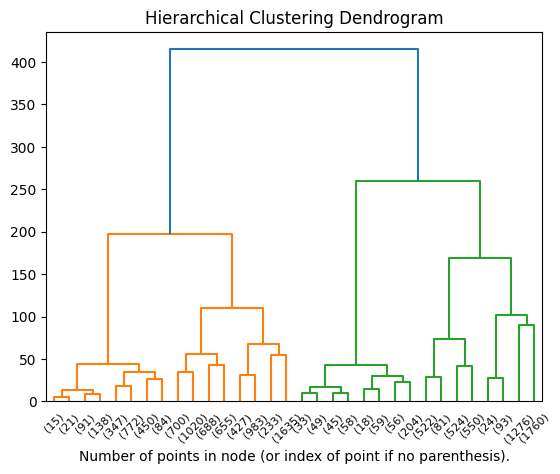

In [32]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    # model.children_[i][0] and model.children_[i][1] are merged at level i
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    # linkage should contain [children_0, children_1, distance, n_points]
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_scaled)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Ward** linkage criterionminimizes the variance of the clusters being merged.

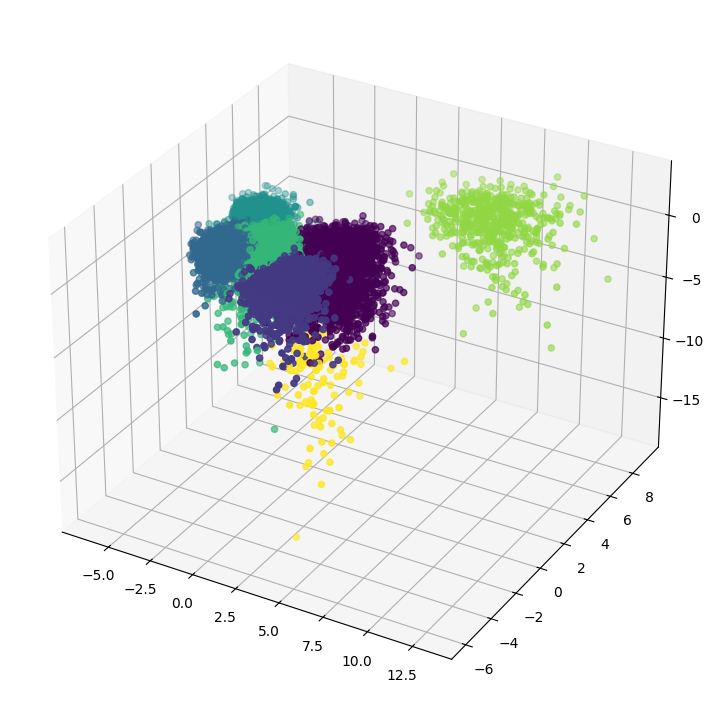

In [33]:
ward = AgglomerativeClustering(n_clusters=7).fit(X_scaled) # ward is default linkage criterion
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0],projection[:,1], projection[:,2],c=ward.labels_)
plt.show()

In [ ]:
print ("kmeans", normalized_mutual_info_score(kmeans_labels, y.flatten()))
print ("dbscan", normalized_mutual_info_score(dbscan.labels_, y.flatten()))
print ("ward's", normalized_mutual_info_score(ward.labels_, y.flatten()))

kmeans 0.7138318734505918
dbscan 0.40636265455686627
ward's 0.7325285591840691


# Additional Resources



*   [PCA main ideas](https://youtu.be/HMOI_lkzW08?si=MVD1p781yipMVAf5)
*   [PCA Step-by-Step](https://youtu.be/FgakZw6K1QQ?si=eYrw0Jx9Iwzw5pcd)
*   [PCA in Python](https://youtu.be/Lsue2gEM9D0?si=pMOlQdAxboxkK_og)
*   [PCA math](https://youtu.be/dhK8nbtii6I?si=8PCuyZn0kT-BLuW3)
*   [t-SNE](https://youtu.be/NEaUSP4YerM?si=HZx3uzCCxG8oNQzC)
*   [Eigenvectors and Eigenvalues](https://youtu.be/PFDu9oVAE-g?si=Ubv-fdszu1_Lqyjp)

